In [8]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [9]:
import os
import sys

sys.path.append("../../../")

import getpass
import pickle
from pathlib import Path

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from relativewealth import nightlights, settings
from relativewealth.dhs import generate_dhs_cluster_level_data
from relativewealth.feature_engineering import (
    categorize_wealth_index,
    generate_features,
)
from relativewealth.iso3 import get_region_name
from relativewealth.rollout_grids import get_region_filtered_bingtile_grids

# Model Prediction on Rollout Grids: Vietnam

This notebook is the final step in the rollout and runs the final model to create relative wealth estimations over populated areas within the given country. The model predictions will have a spatial resolution of 2.4km.

The `predicted relative wealth` value gives us the relative wealth level of an area compared to the rest of the country, which fixes the value range from 0 (lowest wealth) to 1 (highest wealth). In between these extremes, each area's wealth estimate is scaled to a value between 0 and 1. 

The predicted relative wealth value is later binned into 5 wealth categories A-E by dividing the distribution into quintiles (every 20th percentile).

## Set up Data Access
The following cell will prompt you to enter your EOG username and password. See [this page](https://eogdata.mines.edu/products/register/) to learn how to set-up your EOG account.

In [10]:
# Log-in using EOG credentials
username = os.environ.get("EOG_USER", None)
username = username if username is not None else input("Username?")
password = os.environ.get("EOG_PASSWORD", None)
password = password if password is not None else getpass.getpass("Password?")

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username, password, save_token=True)

2023-04-17 15:58:18.815 | INFO     | relativewealth.nightlights:get_eog_access_token:42 - Saving access_token to /home/alron/.eog_creds/eog_access_token.txt
2023-04-17 15:58:18.818 | INFO     | relativewealth.nightlights:get_eog_access_token:50 - Adding access token to environment var EOG_ACCESS_TOKEN


## Set country-specific parameters

In [11]:
COUNTRY_CODE = "vn"
COUNTRY_OSM = get_region_name(COUNTRY_CODE, code="alpha-2").lower()
OOKLA_YEAR = 2019
NIGHTLIGHTS_YEAR = 2021

rollout_date = "-".join(os.getcwd().split("/")[-2].split("-")[:3])
rollout_grids_path = Path(f"./{rollout_date}-{COUNTRY_CODE}-rollout-grids.geojson")
rollout_grids_path

Path('2023-02-21-vn-rollout-grids.geojson')

## Set Model Parameters

In [12]:
# Model to use for prediction
MODEL_SAVE_PATH = Path(f"../{rollout_date}-cross-country-model.pkl")

## Load Country Rollout AOI

The rollout area of interest is split into 2.4km grid tiles (zoom level 14), matching the areas used during model training. The grids are also filtered to only include populated areas based on Meta's High Resolution Settlement Layer (HRSL) data.

Refer to the previous notebook `2_vn_generate_grids.ipynb` for documentation on generating this grid.

In [13]:
aoi = gpd.read_file(rollout_grids_path)
# aoi.explore() # Uncomment to view data in a map

## Generate Features For Rollout AOI

If this is your first time running this notebook for this specific area, expect a long runtime for the following cell as it will download and cache the required datasets. It will then process the relevant features for each area specified. On subsequent runs, the runtime will be much faster as the data is already stored in your filesystem. 

In [14]:
%%time
scaler = MinMaxScaler
rollout_aoi = aoi.copy()

# Create features dataframe using generate_features module
features = generate_features(
    rollout_aoi,
    country_osm=COUNTRY_OSM,
    ookla_year=OOKLA_YEAR,
    nightlights_year=NIGHTLIGHTS_YEAR,
    scaled_only=False,
    sklearn_scaler=scaler,
    features_only=True,
    use_aoi_quadkey=True,
)

2023-04-17 15:58:25.434 | INFO     | relativewealth.osm:download_osm_country_data:198 - OSM Data: Cached data available for vietnam at /home/alron/.geowrangler/osm/vietnam? False
2023-04-17 15:58:25.435 | INFO     | relativewealth.osm:download_osm_country_data:204 - OSM Data: Re-initializing OSM country cache dir at /home/alron/.geowrangler/osm/vietnam...
2023-04-17 15:58:25.436 | INFO     | relativewealth.osm:download_osm_country_data:213 - OSM Data: Downloading Geofabrik zip file...
2023-04-17 15:58:25.435 | INFO     | relativewealth.osm:download_osm_country_data:204 - OSM Data: Re-initializing OSM country cache dir at /home/alron/.geowrangler/osm/vietnam...
2023-04-17 15:58:25.436 | INFO     | relativewealth.osm:download_osm_country_data:213 - OSM Data: Downloading Geofabrik zip file...


2023-04-17 16:00:18.898 | INFO     | relativewealth.osm:download_osm_country_data:232 - OSM Data: Unzipping the zip file...
2023-04-17 16:00:27.169 | INFO     | relativewealth.osm:download_osm_country_data:239 - OSM Data: Successfully downloaded and cached OSM data for vietnam at /home/alron/.geowrangler/osm/vietnam!
2023-04-17 16:00:27.171 | DEBUG    | relativewealth.osm:load_pois:160 - OSM POIs for vietnam being loaded from /home/alron/.geowrangler/osm/vietnam/gis_osm_pois_free_1.shp
2023-04-17 16:00:41.992 | INFO     | relativewealth.osm:download_osm_country_data:198 - OSM Data: Cached data available for vietnam at /home/alron/.geowrangler/osm/vietnam? True
2023-04-17 16:00:41.992 | DEBUG    | relativewealth.osm:load_roads:179 - OSM Roads for vietnam being loaded from /home/alron/.geowrangler/osm/vietnam/gis_osm_roads_free_1.shp
2023-04-17 16:03:17.875 | DEBUG    | relativewealth.ookla:load_type_year_data:79 - Contents of data cache: []
2023-04-17 16:03:17.878 | INFO     | relativew

2023-04-17 16:19:58.887 | INFO     | relativewealth.nightlights:unzip_eog_gzip:224 - Unzipping /home/alron/.geowrangler/nightlights/global/VNL_v21_npp_2021_global_vcmslcfg_c202205302300.average.dat.tif.gz into /home/alron/.geowrangler/nightlights/global/VNL_v21_npp_2021_global_vcmslcfg_c202205302300.average.dat.tif
2023-04-17 16:21:23.534 | INFO     | relativewealth.nightlights:unzip_eog_gzip:235 - Deleting /home/alron/.geowrangler/nightlights/global/VNL_v21_npp_2021_global_vcmslcfg_c202205302300.average.dat.tif.gz
2023-04-17 16:21:23.924 | INFO     | relativewealth.nightlights:clip_raster:248 - Generating clipped raster file from /home/alron/.geowrangler/nightlights/global/VNL_v21_npp_2021_global_vcmslcfg_c202205302300.average.dat.tif to /home/alron/.geowrangler/nightlights/clip/d4fabb4208ec7ad172935fe0cff0922d.tif with bounds [102.15087888   8.5592939  109.46777341  23.38259828] and buffer 0.1
2023-04-17 16:21:26.743 | INFO     | relativewealth.nightlights:generate_clipped_metadata:4

CPU times: user 7min 40s, sys: 57 s, total: 8min 37s
Wall time: 25min 18s


In [15]:
# Save raw features, can be used for validation
raw_features = features[[col for col in features.columns if "_scaled" not in col]]
# Then keep only scaled columns
features = features[[col for col in features.columns if "_scaled" in col]]

## Inspect the generated features

In [16]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50880 entries, 0 to 50879
Data columns (total 61 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   poi_count_scaled                          50880 non-null  float64
 1   atm_count_scaled                          50880 non-null  float64
 2   atm_nearest_scaled                        50880 non-null  float64
 3   bank_count_scaled                         50880 non-null  float64
 4   bank_nearest_scaled                       50880 non-null  float64
 5   bus_station_count_scaled                  50880 non-null  float64
 6   bus_station_nearest_scaled                50880 non-null  float64
 7   cafe_count_scaled                         50880 non-null  float64
 8   cafe_nearest_scaled                       50880 non-null  float64
 9   charging_station_count_scaled             50880 non-null  float64
 10  charging_station_nearest_scaled   

## Run Model on AOI

### Load Model

In [17]:
with open(MODEL_SAVE_PATH, "rb") as f:
    model = pickle.load(f)

### Make Predictions

In [18]:
rollout_aoi["Predicted Relative Wealth Index"] = model.predict(features.values)

## Binning predictions into wealth categories

Afterwards, we label the predicted relative wealth by binning them into 5 categories: `A`, `B`, `C`, `D`, and `E` where `A` is the highest and `E` is the lowest. 

We can create these wealth categories by splitting the output `Predicted Relative Wealth Index` distribution into 5 equally sized **quintiles**, i.e. every 20th percentile. 

This categorization may be modified to suit the context of the target country.

In [19]:
rollout_aoi["Predicted Wealth Category (quintile)"] = categorize_wealth_index(
    rollout_aoi["Predicted Relative Wealth Index"]
).astype(str)

In [20]:
rollout_aoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50880 entries, 0 to 50879
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   quadkey                               50880 non-null  object  
 1   shapeName                             50880 non-null  object  
 2   shapeISO                              50880 non-null  object  
 3   shapeID                               50880 non-null  object  
 4   shapeGroup                            50880 non-null  object  
 5   shapeType                             50880 non-null  object  
 6   pop_count                             50880 non-null  float64 
 7   geometry                              50880 non-null  geometry
 8   Predicted Relative Wealth Index       50880 non-null  float64 
 9   Predicted Wealth Category (quintile)  50880 non-null  object  
dtypes: float64(2), geometry(1), object(7)
memory usage: 3.9+ MB


In [21]:
rollout_aoi.head(2)

,quadkey,shapeName,shapeISO,shapeID,shapeGroup,shapeType,pop_count,geometry,Predicted Relative Wealth Index,Predicted Wealth Category (quintile)
0,13223003120321,Phu Quoc,None,VNM-ADM2-3_0_0-B967,VNM,ADM2,500.753008,"POLYGON ((103.46924 9.29731, 103.46924 9.31899...",0.375743,B
1,13223003120320,Phu Quoc,None,VNM-ADM2-3_0_0-B967,VNM,ADM2,6.106744,"POLYGON ((103.44727 9.29731, 103.44727 9.31899...",0.283086,D


## Save output

In [22]:
%%time
rollout_aoi.to_file(
    f"{rollout_date}-{COUNTRY_CODE}-rollout-output.geojson",
    driver="GeoJSON",
    index=False,
)

CPU times: user 10.8 s, sys: 257 ms, total: 11.1 s
Wall time: 11.2 s


In [23]:
# Join back raw features and save
rollout_output_with_features = rollout_aoi.join(raw_features).join(features)
rollout_output_with_features.to_file(
    f"{rollout_date}-{COUNTRY_CODE}-rollout-output-with-features.geojson",
    driver="GeoJSON",
    index=False,
)

## Visualizations

### Inspect predicted wealth index and output dataframe

array([[<AxesSubplot: title={'center': 'Predicted Relative Wealth Index'}>]],
      dtype=object)

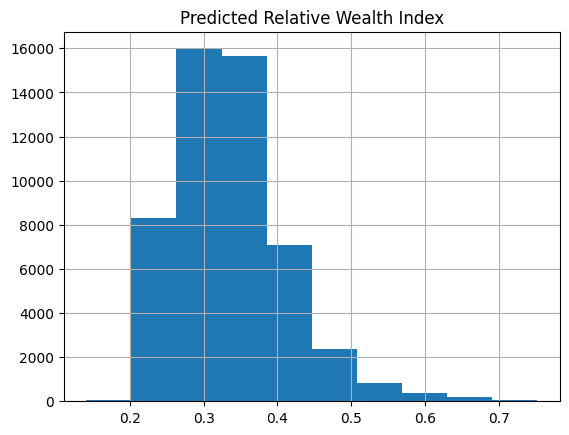

In [24]:
rollout_aoi[["Predicted Relative Wealth Index"]].hist()

### Create Static Maps
#### Plot Predicted Relative Wealth Index

<Figure size 640x480 with 0 Axes>

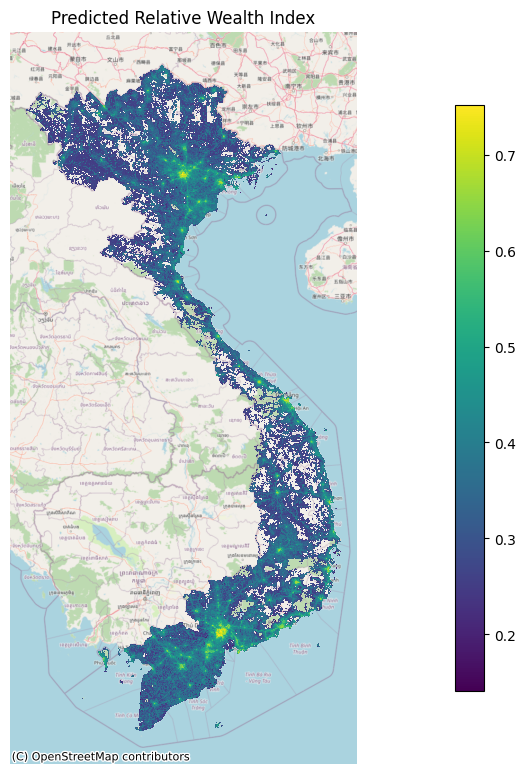

In [25]:
plt.cla()
plt.clf()
rollout_aoi_plot = rollout_aoi.to_crs("EPSG:3857")
ax = rollout_aoi_plot.plot(
    "Predicted Relative Wealth Index",
    figsize=(20, 8),
    cmap="viridis",
    legend=True,
    legend_kwds={"shrink": 0.8},
)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Predicted Relative Wealth Index")
plt.tight_layout()
plt.savefig(f"{rollout_date}-{COUNTRY_CODE}-predicted-wealth-index.png")
plt.show()

#### Plot Predicted Relative Wealth Index Category

<Figure size 640x480 with 0 Axes>

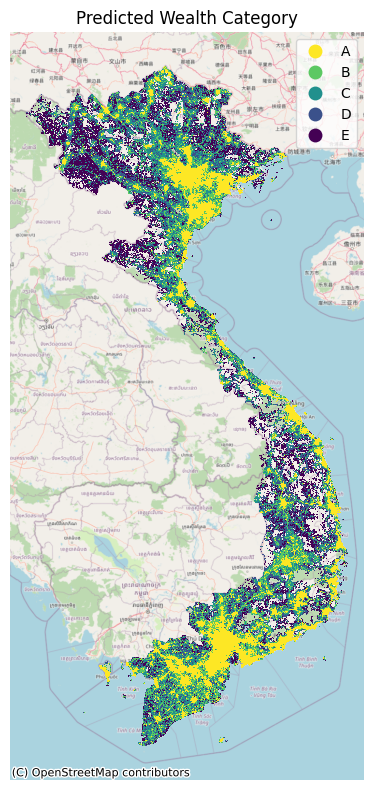

In [26]:
plt.cla()
plt.clf()
rollout_aoi_plot = rollout_aoi.to_crs("EPSG:3857")
ax = rollout_aoi_plot.plot(
    "Predicted Wealth Category (quintile)",
    figsize=(20, 8),
    cmap="viridis_r",
    legend=True,
)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Predicted Wealth Category")
plt.tight_layout()
plt.savefig(f"{rollout_date}-{COUNTRY_CODE}-predicted-wealth-bin.png")
plt.show()

### Create an Interactive Map

In [27]:
cols_of_interest = [
    "quadkey",
    "shapeName",
    "shapeGroup",
    "pop_count",
    "avg_rad_mean",
    "mobile_2019_mean_avg_d_kbps_mean",
    "fixed_2019_mean_avg_d_kbps_mean",
    "poi_count",
    "road_count",
    "Predicted Relative Wealth Index",
    "Predicted Wealth Category (quintile)",
]

# Warning: This can be a bit laggy due to the large amount of tiles being visualized

# Uncomment the ff if you want to viz the raw wealth predictions
# rollout_aoi.explore(column='Predicted Relative Wealth Index', tooltip=cols_of_interest, cmap="viridis")

# Uncomment the ff if you want to view the quintiles
# rollout_aoi.explore(column='Predicted Wealth Category (quintile)', tooltip=cols_of_interest, cmap="viridis_r")

Alternatively, you may also try to visualize this interactively in [Kepler](https://kepler.gl/demo) by uploading the rollout output geojson file.